In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
from astropy.cosmology import FlatLambdaCDM

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

imported h5py...
modules seem to have loaded?


In [2]:
plt.show();
plt.rcParams.update({'font.size':16,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18})

## Comparison plot for merger timescales at z=1,1.5,2

In [3]:
orbit_dict = {}
for snap in [33,40,50]:
    f = h5py.File(f"{paths.path_data}orbitdata_{snap}.hdf5",'r')
    orbit_dict[str(snap)] = {}
    for key, val in f.items():
        orbit_dict[str(snap)][key] = np.array(val)
    f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
snap_dict = {}
for key, val in f.items():
    snap_dict[key] = np.array(val)
f.close()

### Plot of merged and unmerged at each redshift

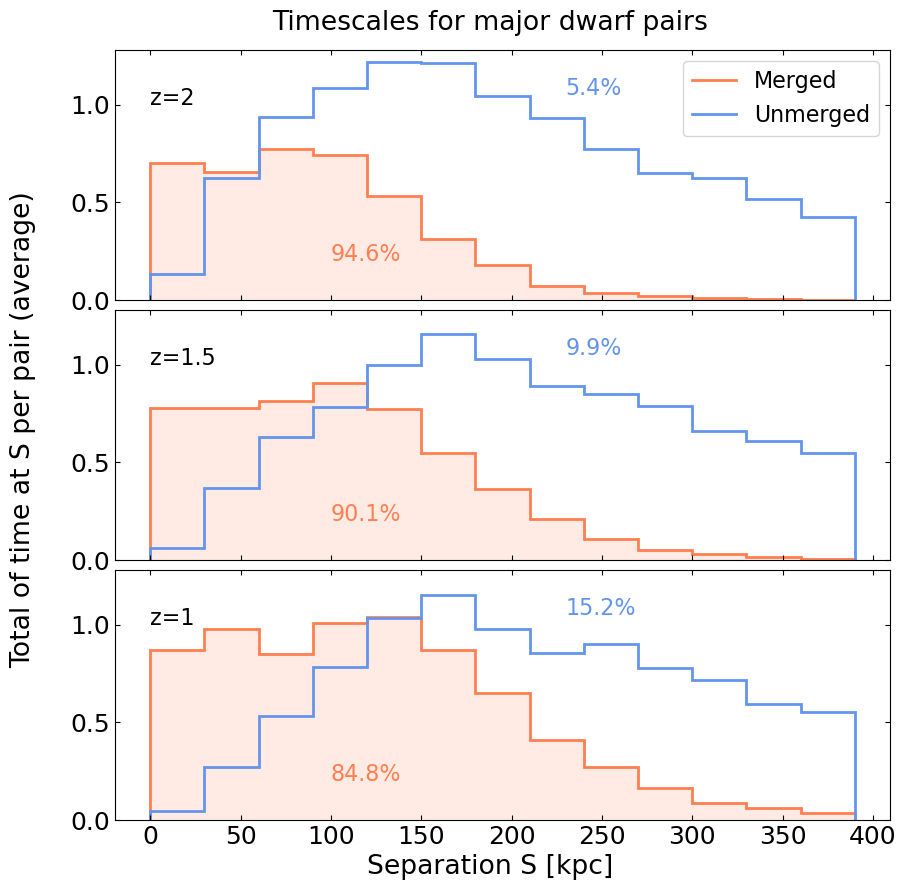

In [48]:
fig, ax = plt.subplots(3, 1, figsize=(10,10), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.10,
                                    "hspace":0.04})
z={"33":"z=2","40":"z=1.5","50":"z=1"}


for ii, snap in enumerate([33, 40, 50]):
    orb = orbit_dict[str(snap)]
    sep_matrix = orb["Separations"]
    elapsed_time = np.diff(snap_dict["Lookback Time"][1:][::-1])
    
    # array of the elapsed time with a nan value in the place of z=0
    elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

    nan_elapsed = np.isnan(elapsed_matrix)
    nan_sep = np.isnan(sep_matrix)
    zero_sep = sep_matrix == 0
    matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep
    
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

    elapsed_masked = elapsed_matrix[matrix_mask]
    sep_masked = sep_matrix[matrix_mask]

    ## calculate histograms
    xx_merge = sep_matrix[matrix_mask&merge_mask]
    xx_unmerge = sep_matrix[matrix_mask&~merge_mask]

    yy_merge = elapsed_matrix[matrix_mask&merge_mask]
    yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]

    num_mergers = np.sum(merge_mask,axis=0)[0]
    num_unmerged = np.sum(~merge_mask,axis=0)[0]
    num_pairs = num_mergers + num_unmerged
    bins = np.arange(0,400,30)

    merged_vals, merged_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge/num_mergers)
    unmerged_vals, unmerged_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge/num_unmerged)

    ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,fill=True,alpha=0.15)
    ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
    ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")
    
    ax[ii].text(0,1,f"{z[str(snap)]}")
    ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
    ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")
    
    
ax[0].legend()
fig.suptitle("Timescales for major dwarf pairs",y=0.92)
fig.supxlabel("Separation S [kpc]",y=0.05)
fig.supylabel("Total of time at S per pair (average)")
plt.show()


### Plot of merged at each redshift and unmerged at each redshift

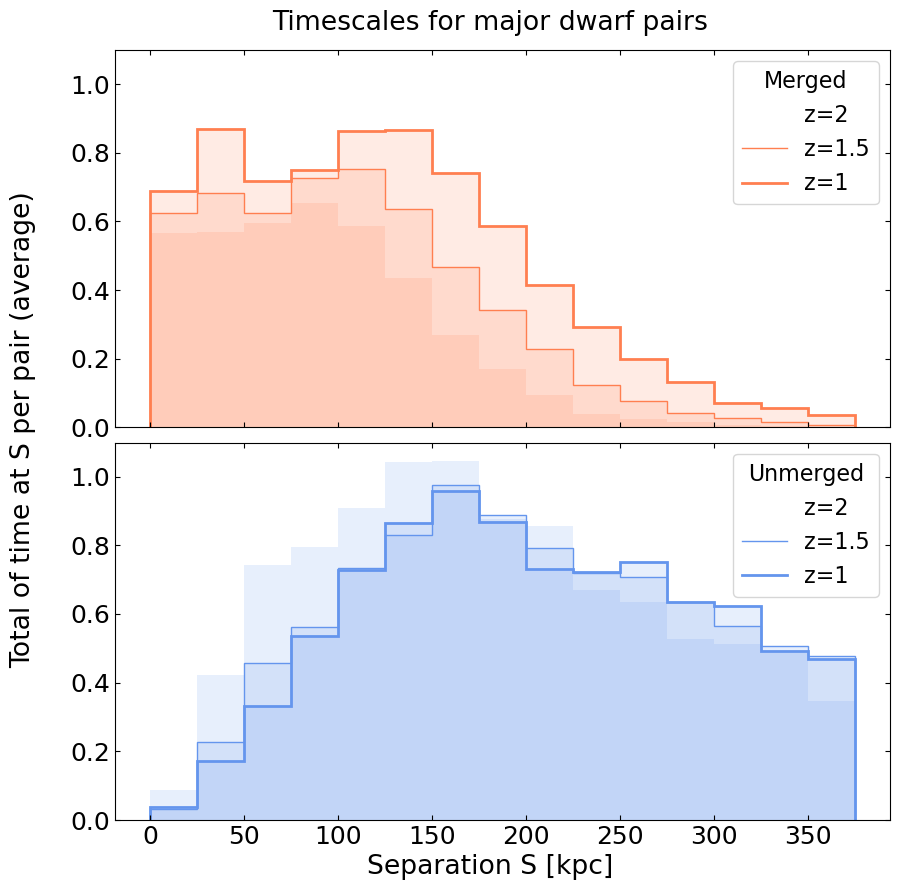

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharey=True, sharex=True, 
                       gridspec_kw={'width_ratios': [1], 
                                    'height_ratios':[1,1],
                                    'wspace': 0.10,
                                    "hspace":0.04})
z={"33":"z=2","40":"z=1.5","50":"z=1"}


for ii, snap in enumerate([33, 40, 50]):
    orb = orbit_dict[str(snap)]
    sep_matrix = orb["Separations"]
    elapsed_time = np.diff(snap_dict["Lookback Time"][1:][::-1])
    
    # array of the elapsed time with a nan value in the place of z=0
    elapsed_noz0 = np.concatenate((np.array([np.nan]),elapsed_time))
    elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

    nan_elapsed = np.isnan(elapsed_matrix)
    nan_sep = np.isnan(sep_matrix)
    zero_sep = sep_matrix == 0
    matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep
    
    merger_array = np.array(orb["MergerFlag"],dtype='bool')
    merge_mask = np.tile(merger_array,(99,1)).transpose()

    elapsed_masked = elapsed_matrix[matrix_mask]
    sep_masked = sep_matrix[matrix_mask]

    ## calculate histograms
    xx_merge = sep_matrix[matrix_mask&merge_mask]
    xx_unmerge = sep_matrix[matrix_mask&~merge_mask]

    yy_merge = elapsed_matrix[matrix_mask&merge_mask]
    yy_unmerge = elapsed_matrix[matrix_mask&~merge_mask]

    num_mergers = np.sum(merge_mask,axis=0)[0]
    num_unmerged = np.sum(~merge_mask,axis=0)[0]
    num_pairs = num_mergers + num_unmerged
    bins = np.arange(0,400,25)

    merged_vals, merged_edges = np.histogram(xx_merge,bins=bins,weights=yy_merge/num_mergers)
    unmerged_vals, unmerged_edges = np.histogram(xx_unmerge,bins=bins,weights=yy_unmerge/num_unmerged)

    ax[0].stairs(merged_vals,merged_edges,color="coral",lw=ii,fill=True,alpha=0.15)
    ax[0].stairs(merged_vals,merged_edges,color="coral",lw=ii,label=f"{z[str(snap)]}")
    ax[1].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=ii,fill=True,alpha=0.15)
    ax[1].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=ii,label=f"{z[str(snap)]}")
    
#     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
#     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")
    
    
ax[0].legend(title="Merged")
ax[1].legend(title="Unmerged")
fig.suptitle("Timescales for major dwarf pairs",y=0.92)
fig.supxlabel("Separation S [kpc]",y=0.05)
fig.supylabel("Total of time at S per pair (average)")
plt.show()
